In [ ]:
#Предметная область: Анализ экономических индикаторов на основе синтетических данных.

#Источник данных: https://www.kaggle.com/datasets/harshvir04/index-value-economic-dataset

#Характер данных: Синтетические данные.

#Атрибуты:
#- Year (год): Год наблюдения.
#- Month (месяц): Месяц наблюдения.
#- Interest Rate (процентная ставка): Процентная ставка, действующая на момент наблюдения.
#- Unemployment Rate (уровень безработицы): Уровень безработицы в процентах на момент наблюдения.
#- Index Price (ценовой индекс): Синтетический индекс фондового рынка, отражающий общие рыночные тренды.

#Описание задачи анализа: Анализ экономических показателей поиск связей и корреляций.

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [9]:
# === ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ ===
def load_and_prepare_data(file_path):
    """
    Загрузка датасета и предобработка данных.
    """
    # Загрузка данных с явным указанием разделителя
    data = pd.read_csv(file_path, sep=",")  

    # Проверка на корректность загрузки
    if data.shape[1] == 1:
        raise ValueError("Файл загружается как один столбец. Проверьте разделитель и структуру данных.")
    
    # Приведение названий столбцов к нижнему регистру
    data.columns = data.columns.str.strip().str.lower().str.replace(" ", "_")

    # Конвертация года и месяца в объект даты
    data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

    # Создание бинарной целевой переменной
    threshold = data['index_price'].mean()
    data['high_index'] = (data['index_price'] >= threshold).astype(int)

    return data

# Загрузка данных
file_path = "modified_synthetic_economic_data.csv"  # Укажите правильный путь
data = load_and_prepare_data(file_path)

# Вывод первых строк для проверки
print(data.head())

   year  month  interest_rate  unemployment_rate  index_price       date  \
0  1924      1           3.50               5.19   534.714897 1924-01-01   
1  1925      1           2.86               4.36   424.911412 1925-01-01   
2  1926      1           3.65               5.18   582.253910 1926-01-01   
3  1927      1           4.52               5.81   784.797318 1927-01-01   
4  1928      1           2.77               5.07   321.169866 1928-01-01   

   high_index  
0           1  
1           1  
2           1  
3           1  
4           0  


In [10]:
# === ПОДГОТОВКА ПРИЗНАКОВ И ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===
# Используем interest_rate и unemployment_rate в качестве признаков
X = data[['interest_rate', 'unemployment_rate']]
y = data['high_index']

# Масштабирование признаков
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [11]:
# === ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ ===
# 1. kNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# 2. Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

=== ОЦЕНКА KNN ===
=== kNN ===
Accuracy: 0.9861
Precision: 0.9797
Recall: 0.9948
F1-score: 0.9872
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       166
           1       0.98      0.99      0.99       194

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360

=== ОЦЕНКА DECISION TREE ===
=== Decision Tree ===
Accuracy: 0.9806
Precision: 0.9895
Recall: 0.9742
F1-score: 0.9818
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       166
           1       0.99      0.97      0.98       194

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

kNN ROC-AUC: 0.9993
Decision Tree ROC-AUC: 0.9811


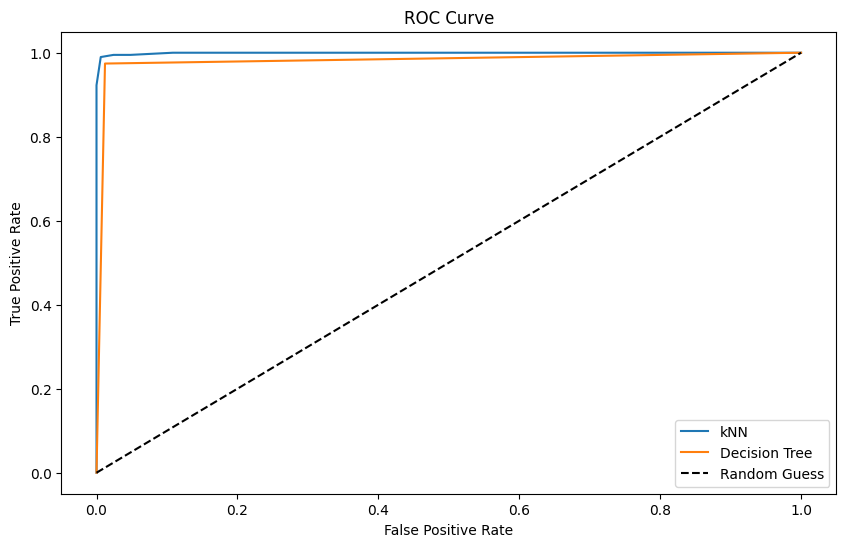

In [12]:
# === МЕТРИКИ КАЧЕСТВА ===
def evaluate_model(name, y_true, y_pred):
    print(f"=== {name} ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))

# Оценка моделей
print("=== ОЦЕНКА KNN ===")
evaluate_model("kNN", y_test, y_pred_knn)

print("=== ОЦЕНКА DECISION TREE ===")
evaluate_model("Decision Tree", y_test, y_pred_dt)

# ROC-AUC
y_pred_proba_knn = knn.predict_proba(X_test)[:, 1]
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]

print(f"kNN ROC-AUC: {roc_auc_score(y_test, y_pred_proba_knn):.4f}")
print(f"Decision Tree ROC-AUC: {roc_auc_score(y_test, y_pred_proba_dt):.4f}")

# === ПОСТРОЕНИЕ ROC-КРИВЫХ ===
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)

plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, label="kNN")
plt.plot(fpr_dt, tpr_dt, label="Decision Tree")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Анализ результатов показал, что обе модели классификации, kNN и Decision Tree, справляются с задачей предсказания целевой переменной на высоком уровне.

Модель kNN продемонстрировала превосходные результаты. Точность (Accuracy) составила 98.61%, что говорит о том, что модель практически не допускает ошибок. Метрики Precision (97.97%) и Recall (99.48%) подтверждают, что модель одинаково хорошо классифицирует как положительные, так и отрицательные классы. F1-метрика составила 98.72%, что указывает на баланс между точностью и полнотой. Значение ROC-AUC, равное 0.9993, говорит о практически идеальном разделении классов, что также видно на графике ROC-кривой.

Модель Decision Tree также показала хорошие результаты. ROC-AUC составил 0.9811, что немного ниже, чем у kNN, но все еще является очень высоким показателем. На графике ROC-кривой видно, что линия для дерева решений расположена чуть ниже, чем для kNN. Остальные метрики, такие как точность, полнота и F1-метрика, также находятся на высоком уровне.

В целом, обе модели показывают высокую точность и демонстрируют способность эффективно классифицировать данные. Однако kNN немного превосходит Decision Tree по метрикам качества, особенно по ROC-AUC.